<a href="https://colab.research.google.com/github/bhuvan-thekkade-hub/industry-classification/blob/main/svm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Data:
                Company Name  \
0     ADSOUTH PARTNERS, INC.   
1   Artec Global Media, Inc.   
2             Betawave Corp.   
3          BOSTON OMAHA Corp   
4  Bright Mountain Media Inc   

                                Business Description  \
0  Adsouth Partners, Inc. provides advertising ag...   
1  Artec Global Media, Inc., formerly Artec Consu...   
2  Betawave Corporation provides online marketing...   
3  Boston Omaha Corporation is engaged in the bus...   
4  Bright Mountain Media, Inc. is a digital media...   

  Industry Classification Tag  
0                 Advertising  
1                 Advertising  
2                 Advertising  
3                 Advertising  
4                 Advertising  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6045 entries, 0 to 6044
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Company Name                 6045 non-

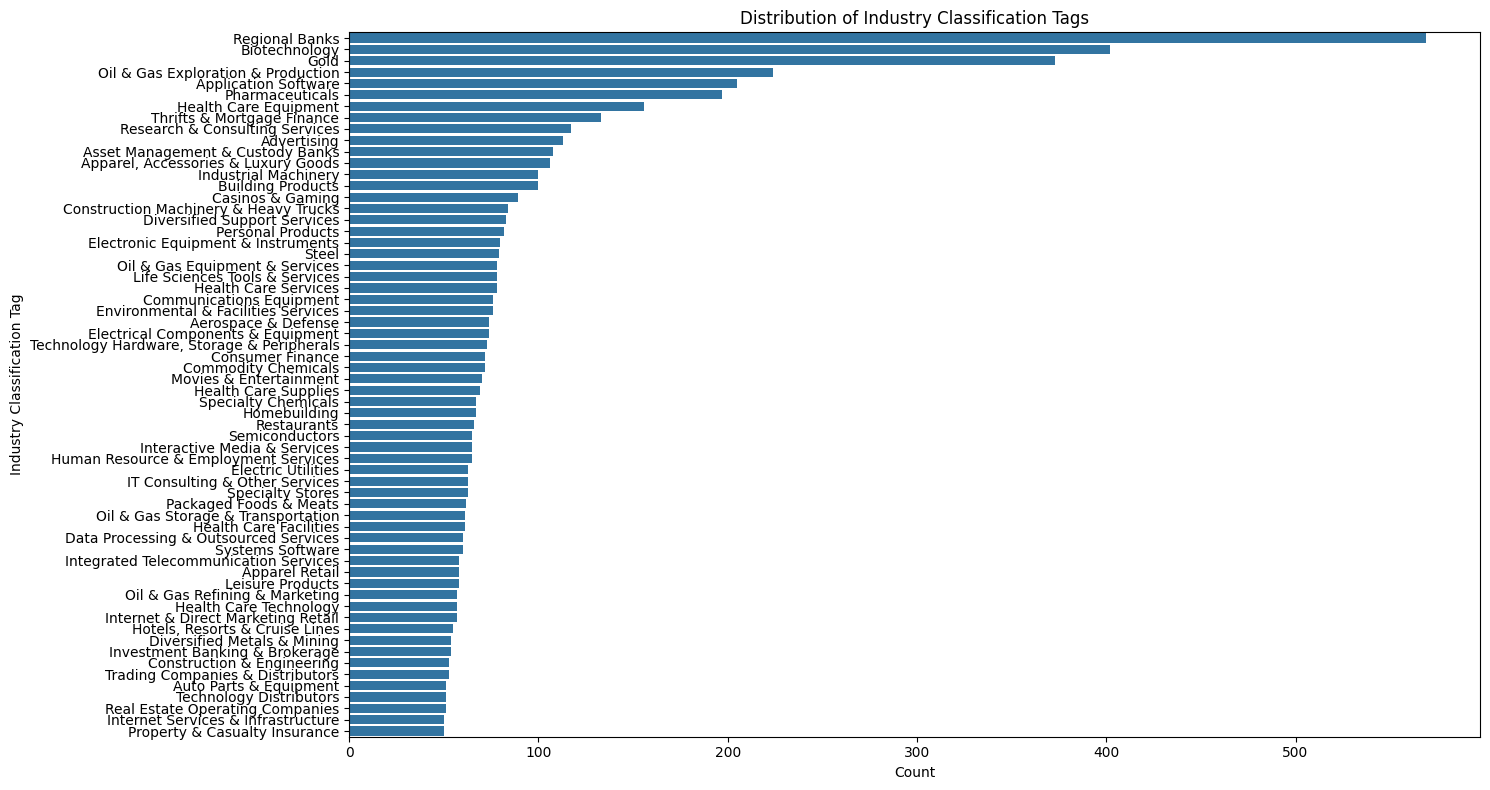

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and testing datasets
df_train = pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study (1).xlsx')
df_test = pd.read_excel('Testing_Data_for_Data_Science_Case_Stduy (1).xlsx')

# Display the first 5 rows and column information for the training data
print('Training Data:')
print(df_train.head())
print(df_train.info())

# Display the first 5 rows and column information for the testing data
print('\nTesting Data:')
print(df_test.head())
print(df_test.info())

# Check for missing values in 'Business Description' and duplicates
print(f"Rows with missing values in training data: {df_train['Business Description'].isnull().sum()}")
print(f"Number of duplicate rows in training data: {df_train.duplicated().sum()}")

# Visualize the distribution of the target variable
plt.figure(figsize=(15, 8))
sns.countplot(y='Industry Classification Tag', data=df_train, order = df_train['Industry Classification Tag'].value_counts().index)
plt.title('Distribution of Industry Classification Tags')
plt.xlabel('Count')
plt.ylabel('Industry Classification Tag')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK data (run once)
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# --- 1. Data Loading and Preprocessing ---
# Load and clean training data
df_train = pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study (1).xlsx', sheet_name='DatascienceCasestudy')
df_train.dropna(subset=['Business Description'], inplace=True)
df_train.drop_duplicates(inplace=True)

# Load and clean test data
df_test = pd.read_excel('Testing_Data_for_Data_Science_Case_Stduy (1).xlsx', sheet_name='Sheet1')
df_test.dropna(subset=['Business Description'], inplace=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_and_lemmatize(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(lemmatized_tokens)

df_train['clean_description'] = df_train['Business Description'].apply(clean_and_lemmatize)

# --- 2. Define Groups for Hierarchical Classification ---
major_groups = {
    'Health Care': [
        'Biotechnology', 'Pharmaceuticals', 'Health Care Equipment', 'Health Care Services',
        'Life Sciences Tools & Services', 'Health Care Supplies', 'Health Care Facilities', 'Health Care Technology'
    ],
    'Financials': [
        'Regional Banks', 'Consumer Finance', 'Investment Banking & Brokerage',
        'Property & Casualty Insurance', 'Thrifts & Mortgage Finance',
        'Asset Management & Custody Banks', 'Diversified Support Services'
    ],
    'Technology': [
        'Application Software', 'Communications Equipment', 'IT Consulting & Other Services',
        'Interactive Media & Services', 'Internet & Direct Marketing Retail',
        'Internet Services & Infrastructure', 'Semiconductors',
        'Systems Software', 'Technology Distributors',
        'Technology Hardware, Storage & Peripherals'
    ],
    'Manufacturing & Industrial': [
        'Auto Parts & Equipment', 'Building Products', 'Construction & Engineering',
        'Construction Machinery & Heavy Trucks', 'Industrial Machinery',
        'Specialty Chemicals', 'Trading Companies & Distributors'
    ],
    'Consumer Goods & Services': [
        'Apparel Retail', 'Restaurants', 'Hotels, Resorts & Cruise Lines',
        'Personal Products', 'Packaged Foods & Meats'
    ],
    'Materials & Mining': [
        'Gold', 'Steel', 'Diversified Metals & Mining', 'Commodity Chemicals'
    ],
    'Infrastructure & Utilities': [
        'Electric Utilities', 'Environmental & Facilities Services', 'Building Products'
    ],
    'Oil & Gas': [
        'Oil & Gas Equipment & Services', 'Oil & Gas Exploration & Production',
        'Oil & Gas Refining & Marketing', 'Oil & Gas Storage & Transportation'
    ],
    'Media & Entertainment': [
        'Movies & Entertainment', 'Advertising'
    ],
    'Professional Services': [
        'Human Resource & Employment Services', 'Research & Consulting Services'
    ]
}

# Identify all industries that will be categorized as "Miscellaneous"
all_classified_tags = [item for sublist in major_groups.values() for item in sublist]

df_train['High-Level Group'] = df_train['Industry Classification Tag'].apply(
    lambda x: next((group for group, tags in major_groups.items() if x in tags), 'Miscellaneous')
)

# --- 3. Train the Primary Sorter ---
X_final = df_train['clean_description']
y_final = df_train['High-Level Group']

le_final = LabelEncoder()
y_final_encoded = le_final.fit_transform(y_final)

# Split data to get accuracy report for primary sorter
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final_encoded, test_size=0.2, random_state=42, stratify=y_final_encoded
)

vectorizer_final = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
X_train_final_vec = vectorizer_final.fit_transform(X_train_final)
X_test_final_vec = vectorizer_final.transform(X_test_final)

svm_primary_sorter_model = SVC(kernel='linear', C=1.0, class_weight='balanced')
svm_primary_sorter_model.fit(X_train_final_vec, y_train_final)

y_pred_final = svm_primary_sorter_model.predict(X_test_final_vec)

print("="*50)
print("Classification Report for Primary Sorter Model")
print("="*50)
print(classification_report(y_test_final, y_pred_final, target_names=le_final.classes_))
print("\n")


# --- 4. Train all Specialized Models & Display Accuracy ---
specialized_models = {}
specialized_encoders = {}
specialized_vectorizers = {}

for group_name, tags in major_groups.items():
    df_group = df_train[df_train['Industry Classification Tag'].isin(tags)].copy()

    if len(df_group) > 10:
        print("="*50)
        print(f"Training and Evaluating: {group_name} Specialized Model")
        print("="*50)

        X_group = df_group['clean_description']
        y_group = df_group['Industry Classification Tag']

        le_group = LabelEncoder()
        y_group_encoded = le_group.fit_transform(y_group)

        # Split data to get accuracy report for specialized model
        X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(
            X_group, y_group_encoded, test_size=0.2, random_state=42, stratify=y_group_encoded
        )

        vectorizer_group = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
        X_train_group_vec = vectorizer_group.fit_transform(X_train_group)
        X_test_group_vec = vectorizer_group.transform(X_test_group)


        svm_group_model = SVC(kernel='linear', C=1.0, class_weight='balanced')
        svm_group_model.fit(X_train_group_vec, y_train_group)

        y_pred_group = svm_group_model.predict(X_test_group_vec)

        print(classification_report(y_test_group, y_pred_group, target_names=le_group.classes_))

        specialized_models[group_name] = svm_group_model
        specialized_encoders[group_name] = le_group
        specialized_vectorizers[group_name] = vectorizer_group

# --- 5. Final Unified Prediction Function ---
def predict_industry_tag(description):
    cleaned_description = clean_and_lemmatize(description)

    broad_prediction_encoded = svm_primary_sorter_model.predict(vectorizer_final.transform([cleaned_description]))
    broad_group = le_final.inverse_transform(broad_prediction_encoded)[0]

    if broad_group in specialized_models:
        specialist_model = specialized_models[broad_group]
        specialist_encoder = specialized_encoders[broad_group]
        specialist_vectorizer = specialized_vectorizers[broad_group]

        final_prediction_encoded = specialist_model.predict(specialist_vectorizer.transform([cleaned_description]))
        final_tag = specialist_encoder.inverse_transform(final_prediction_encoded)[0]
        return final_tag
    else:
        return 'Miscellaneous'

# --- 6. Predict on New Test Data and Display Results ---
print("="*50)
print("Predicting on Test Data")
print("="*50)

# The code will now use the corrected 'Company' and 'Business Description' columns.
df_test['Predicted Tag'] = df_test['Business Description'].apply(predict_industry_tag)

print(df_test[['Company ', 'Business Description', 'Predicted Tag']].head(15))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Classification Report for Primary Sorter Model
                            precision    recall  f1-score   support

 Consumer Goods & Services       0.66      0.72      0.69        65
                Financials       0.95      0.92      0.93       212
               Health Care       0.93      0.90      0.91       220
Infrastructure & Utilities       0.65      0.63      0.64        27
Manufacturing & Industrial       0.66      0.81      0.73       100
        Materials & Mining       0.91      0.87      0.89       110
     Media & Entertainment       0.56      0.67      0.61        36
             Miscellaneous       0.57      0.55      0.56       153
                 Oil & Gas       0.95      0.90      0.93        83
     Professional Services       0.72      0.72      0.72        36
                Technology       0.76      0.73      0.74       153

                  accuracy                           0.80      1195
                 macro avg       0.76      0.77      0.76      1195

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score
# import re
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords
# import nltk

# # Download necessary NLTK data (run once)
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

# # --- 1. Data Loading and Preprocessing ---
# # Load and clean training data
# df_train = pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study (1).xlsx', sheet_name='DatascienceCasestudy')
# df_train.dropna(subset=['Business Description'], inplace=True)
# df_train.drop_duplicates(inplace=True)

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def clean_and_lemmatize(text):
#     if not isinstance(text, str):
#         return ""
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = text.lower()
#     tokens = text.split()
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
#     return ' '.join(lemmatized_tokens)

# df_train['clean_description'] = df_train['Business Description'].apply(clean_and_lemmatize)

# # --- 2. Define Groups for Hierarchical Classification ---
# major_groups = {
#     'Health Care': [
#         'Biotechnology', 'Pharmaceuticals', 'Health Care Equipment', 'Health Care Services',
#         'Life Sciences Tools & Services', 'Health Care Supplies', 'Health Care Facilities', 'Health Care Technology'
#     ],
#     'Financials': [
#         'Regional Banks', 'Consumer Finance', 'Investment Banking & Brokerage',
#         'Property & Casualty Insurance', 'Thrifts & Mortgage Finance',
#         'Asset Management & Custody Banks', 'Diversified Support Services'
#     ],
#     'Technology': [
#         'Application Software', 'Communications Equipment', 'IT Consulting & Other Services',
#         'Interactive Media & Services', 'Internet & Direct Marketing Retail',
#         'Internet Services & Infrastructure', 'Semiconductors',
#         'Systems Software', 'Technology Distributors',
#         'Technology Hardware, Storage & Peripherals'
#     ],
#     'Manufacturing & Industrial': [
#         'Auto Parts & Equipment', 'Building Products', 'Construction & Engineering',
#         'Construction Machinery & Heavy Trucks', 'Industrial Machinery',
#         'Specialty Chemicals', 'Trading Companies & Distributors'
#     ],
#     'Consumer Goods & Services': [
#         'Apparel Retail', 'Restaurants', 'Hotels, Resorts & Cruise Lines',
#         'Personal Products', 'Packaged Foods & Meats'
#     ],
#     'Materials & Mining': [
#         'Gold', 'Steel', 'Diversified Metals & Mining', 'Commodity Chemicals'
#     ],
#     'Infrastructure & Utilities': [
#         'Electric Utilities', 'Environmental & Facilities Services', 'Building Products'
#     ],
#     'Oil & Gas': [
#         'Oil & Gas Equipment & Services', 'Oil & Gas Exploration & Production',
#         'Oil & Gas Refining & Marketing', 'Oil & Gas Storage & Transportation'
#     ],
#     'Media & Entertainment': [
#         'Movies & Entertainment', 'Advertising'
#     ],
#     'Professional Services': [
#         'Human Resource & Employment Services', 'Research & Consulting Services'
#     ]
# }

# df_train['High-Level Group'] = df_train['Industry Classification Tag'].apply(
#     lambda x: next((group for group, tags in major_groups.items() if x in tags), 'Miscellaneous')
# )

# # --- 3. Train the Primary Sorter ---
# X_final = df_train['clean_description']
# y_final = df_train['High-Level Group']

# le_final = LabelEncoder()
# y_final_encoded = le_final.fit_transform(y_final)

# # Split data into training and testing sets
# X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
#     X_final, y_final_encoded, test_size=0.2, random_state=42, stratify=y_final_encoded
# )

# vectorizer_final = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
# X_train_final_vec = vectorizer_final.fit_transform(X_train_final)
# X_test_final_vec = vectorizer_final.transform(X_test_final)

# svm_primary_sorter_model = SVC(kernel='linear', C=1.0, class_weight='balanced')
# svm_primary_sorter_model.fit(X_train_final_vec, y_train_final)

# # Make predictions on the test set
# y_pred_final = svm_primary_sorter_model.predict(X_test_final_vec)

# # Calculate and print the overall accuracy
# overall_accuracy = accuracy_score(y_test_final, y_pred_final)
# print("="*50)
# print(f"Overall Accuracy of the Primary Sorter: {overall_accuracy:.2f}")
# print("="*50)

# # Optional: You can still see the detailed report
# print(classification_report(y_test_final, y_pred_final, target_names=le_final.classes_))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Overall Accuracy of the Primary Sorter: 0.80
                            precision    recall  f1-score   support

 Consumer Goods & Services       0.66      0.72      0.69        65
                Financials       0.95      0.92      0.93       212
               Health Care       0.93      0.89      0.91       220
Infrastructure & Utilities       0.65      0.63      0.64        27
Manufacturing & Industrial       0.66      0.81      0.73       100
        Materials & Mining       0.91      0.87      0.89       110
     Media & Entertainment       0.56      0.67      0.61        36
             Miscellaneous       0.58      0.55      0.56       153
                 Oil & Gas       0.95      0.90      0.93        83
     Professional Services       0.71      0.69      0.70        36
                Technology       0.75      0.73      0.74       153

                  accuracy                           0.80      1195
                 macro avg       0.75      0.76      0.76      1195
 

In [ ]:
df_miscellaneous = df_test[df_test['Predicted Tag'] == 'Miscellaneous']
display(df_miscellaneous[['Company ', 'Business Description', 'Predicted Tag']])

,Company,Business Description,Predicted Tag
14,MPIL Corporation Ltd,MPIL Corporation Limited is an India-based com...,Miscellaneous
21,Kaycee Industries Ltd,Kaycee Industries Limited is engaged in the ma...,Miscellaneous
22,Panasonic Energy India Co Ltd,Panasonic Energy India Company Limited is enga...,Miscellaneous
23,High Energy Batteries (India) Ltd,High Energy Batteries (India) Limited is an In...,Miscellaneous
45,Kemp and Company Ltd,Kemp & Company Limited is an India-based compa...,Miscellaneous
...,...,...,...
741,Transformers & Rectifiers (India) Ltd.,Transformers & Rectifiers (India) Limited is a...,Miscellaneous
745,Ujaas Energy Ltd,"Ujaas Energy Limited, formerly M&B Switchgears...",Miscellaneous
752,Vakrangee Ltd,Vakrangee Limited is a technology company. The...,Miscellaneous
762,Voltamp Transformers Limited,Voltamp Transformers Limited is engaged in the...,Miscellaneous


# Task
Push the current notebook to the GitHub repository "https://github.com/bhuvan-thekkade-hub/classification based on description".

## Install and authenticate with the github cli

### Subtask:
Install the GitHub command-line interface and authenticate with your GitHub account.


**Reasoning**:
Install the GitHub CLI and authenticate it.



**Reasoning**:
Continue with the authentication process by selecting GitHub.com and then choosing the web browser method.

